In [35]:
import pandas as pd
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import polars as pl
import polars.selectors as cs
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns
from colorama import Fore, Style
from scipy.optimize import minimize


In [36]:
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import os
from tqdm import tqdm

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df, filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    return stats, indexes

In [37]:
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
%matplotlib inline

# 0. Task


The aim is to predict the sii (Severity Impairment Index), which is directly derived from PCIAT_PCIAT_Total, the sum of scores from 20 questions scored 0-5 from Parent-Child Internet Addiction Test Instrument, based on physical activity data and other features

# 1. Load data

In [38]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

In [39]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 24.71it/s]


# 2. Overview

## 2.1 Shape of tabular data


In [40]:
display(train.head())
print(f"Train shape: {train.shape}")

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


Train shape: (3960, 82)


In [41]:
display(test.head())
print(f"Test shape: {test.shape}")


id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,enum,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,null,null,null,"""Fall""",3
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",46,64,"""Summer""",0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",38,54,"""Summer""",2
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",31,45,"""Winter""",0
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null


Test shape: (20, 59)


In [42]:
data_dict

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


## 2.2 Missing tabular data

**The test set does not have PCIAT columns**

In [43]:
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


**Parent-Child Internet Addiction Test (PCIAT):** contains 20 items (`PCIAT-PCIAT_01` to `PCIAT-PCIAT_20`), each assessing a different aspect of a child's behavior related to internet use. The items are answered on a scale (from 0 to 5), and the total score provides an indication of the severity of internet addiction.

We also have season of participation in `PCIAT-Season` and total Score in `PCIAT-PCIAT_Total`; so there are 22 PCIAT test-related columns in total.

Let's verify that the `PCIAT-PCIAT_Total` align with the corresponding sii categories according to the competition description by calculating its minimum and maximum scores for each sii category:

In [44]:
train_tmp = train.to_pandas()
pciat_min_max = train_tmp.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'}
)
display(pciat_min_max)
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

In [45]:
train["sii"].value_counts()

sii,count
i64,u32
0,1594
1,730
3,34
null,1224
2,378


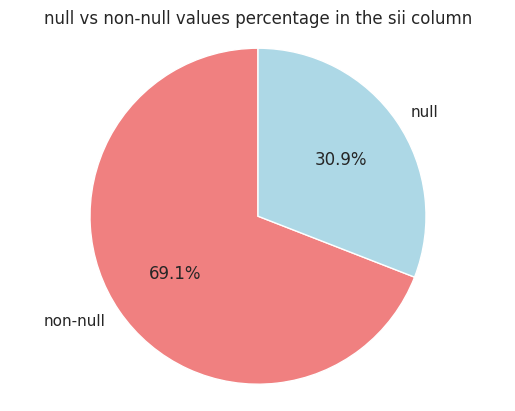

In [46]:
null_count = train.select(pl.col('sii').is_null().sum()).to_pandas().iloc[0, 0]  
non_null_count = len(train) - null_count  
labels = [ 'non-null','null']
sizes = [non_null_count, null_count]
colors = ['lightcoral', 'lightblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('null vs non-null values percentage in the sii column')
plt.axis('equal') 
plt.show()


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
Note: The training data has no target for 1/3 of total samples

</div>

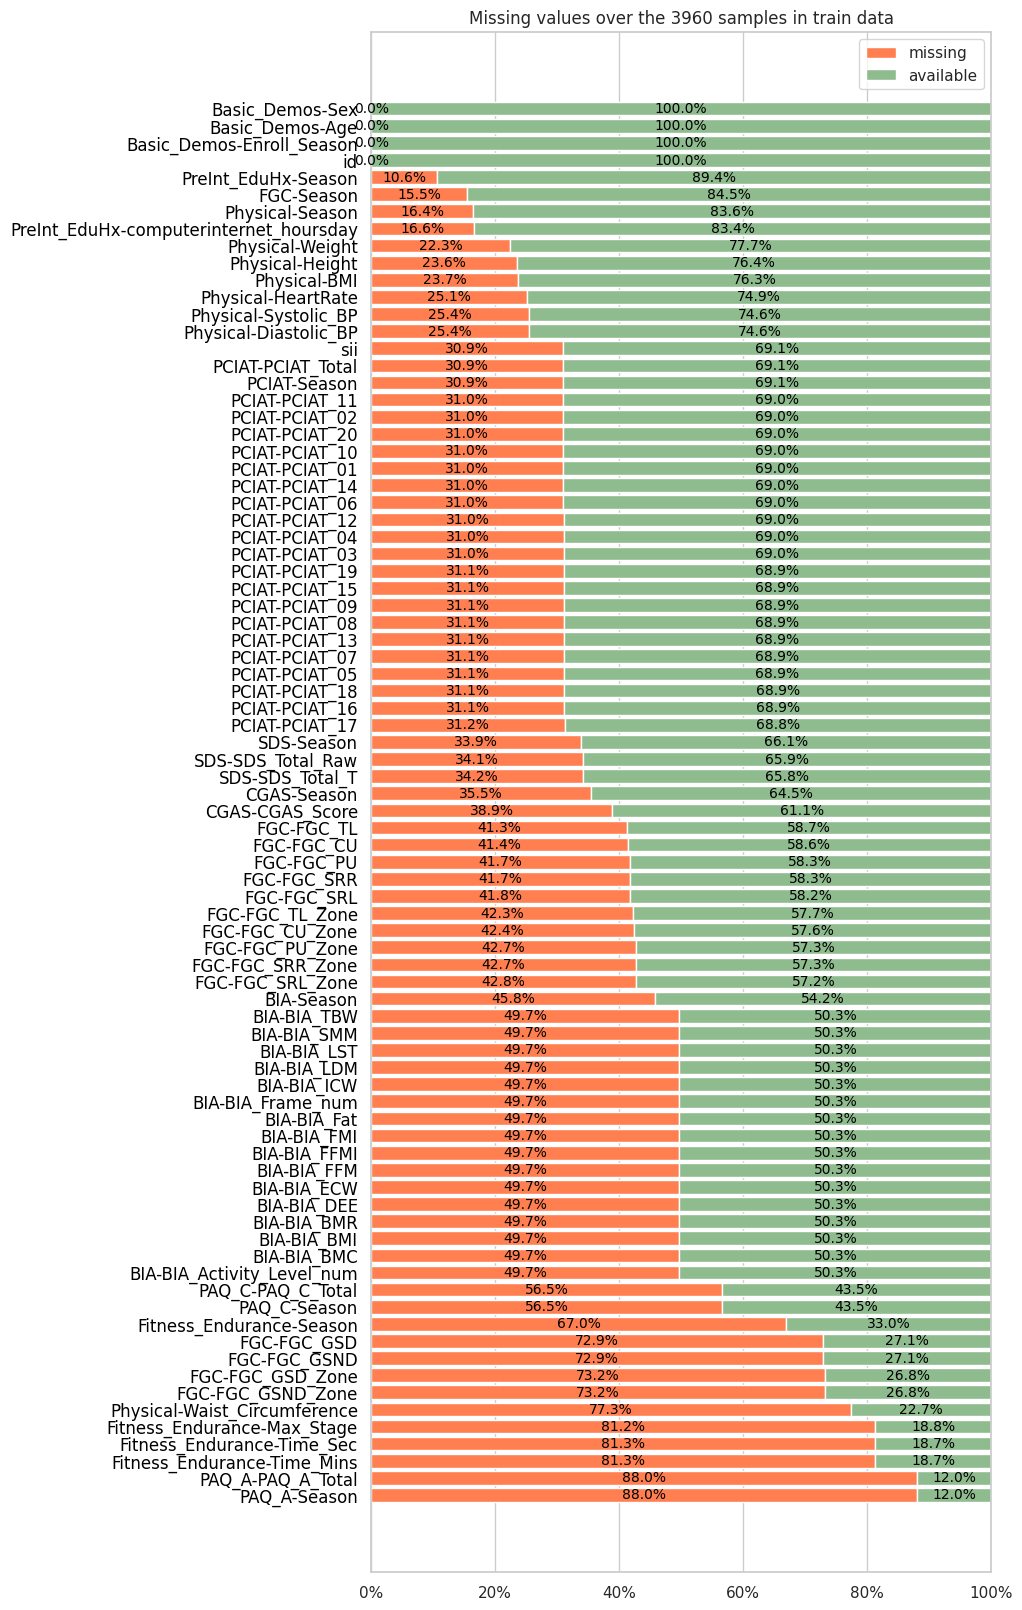

In [47]:
missing_count = (
    train
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(train)).alias('null_ratio'))
)

# Parameters
BAR_HEIGHT = 0.8  # Adjusted bar height for increased spacing
LABEL_COLOR = 'black'  

# Prepare the plot
plt.figure(figsize=(8, 20))
plt.title(f'Missing values over the {len(train)} samples in train data')
plt.barh(
    np.arange(len(missing_count)),
    missing_count.get_column('null_ratio'),
    color='coral', label='missing', height=BAR_HEIGHT
)
plt.barh(
    np.arange(len(missing_count)),
    1 - missing_count.get_column('null_ratio'),
    left=missing_count.get_column('null_ratio'),
    color='darkseagreen', label='available', height=BAR_HEIGHT
)

# Add y-ticks
plt.yticks(
    np.arange(len(missing_count)), 
    missing_count.get_column('feature'), 
    color=LABEL_COLOR,  # Set y-tick label color
    fontsize=12  # Adjust font size for better readability
)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)

# Add percentage labels
for i, ratio in enumerate(missing_count.get_column('null_ratio')):
    # Missing percentage
    plt.text(
        ratio / 2, i,
        f'{ratio * 100:.1f}%',
        ha='center', va='center', color=LABEL_COLOR, fontsize=10
    )
    # Available percentage
    plt.text(
        ratio + (1 - ratio) / 2, i,
        f'{(1 - ratio) * 100:.1f}%',
        ha='center', va='center', color=LABEL_COLOR, fontsize=10
    )

# Add legend and show the plot
plt.legend()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    Note:
    
    - Out of all features only Basic_Demos features (3 features) have no missing values

    - There are features with very high missing data percentage (some over 80%) like Fitness_Endurance_Time Sec, Fitness_Endurance_Time_Mins, Fitness_Endurance_Max Stage, implying that the data collection process is flawed or the data was not recorded properly. 

    - Some features with low missing data percentage like PreInt_EduHx-computerinternet_hoursday, Basic_Demos features shows that the quality of these features is better than others and can be used for models directly without data imputation

    - Features with similiar missing values percentage tend to come from the same Instrument, which means missing data is concentrated.
</div>

In [48]:
total_values = len(train) * len(train.columns)
total_missing = train.null_count().sum_horizontal().to_numpy()[0]
missing_percentage = (total_missing / total_values) * 100
print(f"Missing Percentage for the train dataset: {missing_percentage:.2f}%")

Missing Percentage for the train dataset: 40.56%


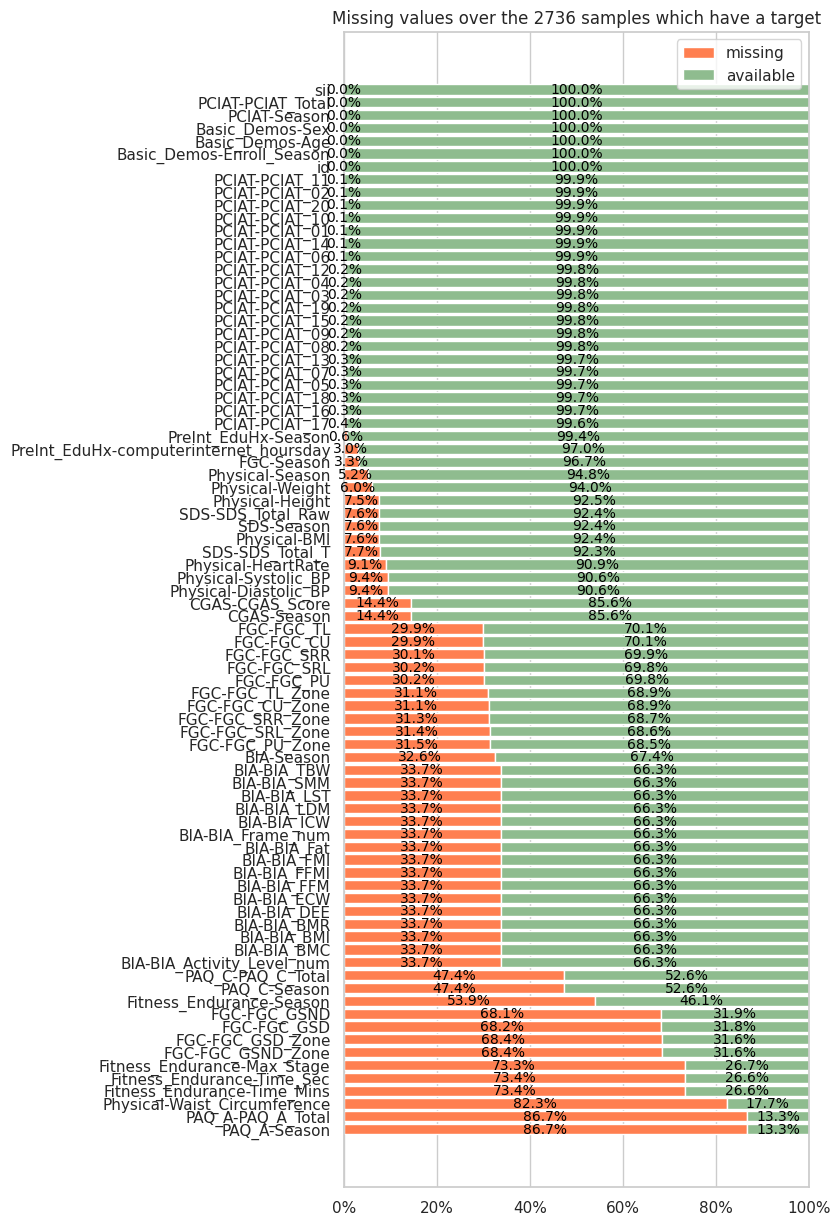

In [49]:
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)

missing_count = (
    supervised_usable
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))
)
plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
for i, ratio in enumerate(missing_count.get_column('null_ratio')):
    # Missing percentage
    plt.text(
        ratio / 2, i,
        f'{ratio * 100:.1f}%',
        ha='center', va='center', color=LABEL_COLOR, fontsize=10
    )
    # Available percentage
    plt.text(
        ratio + (1 - ratio) / 2, i,
        f'{(1 - ratio) * 100:.1f}%',
        ha='center', va='center', color=LABEL_COLOR, fontsize=10
    )
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

## 2.3. Box plots

### Physical

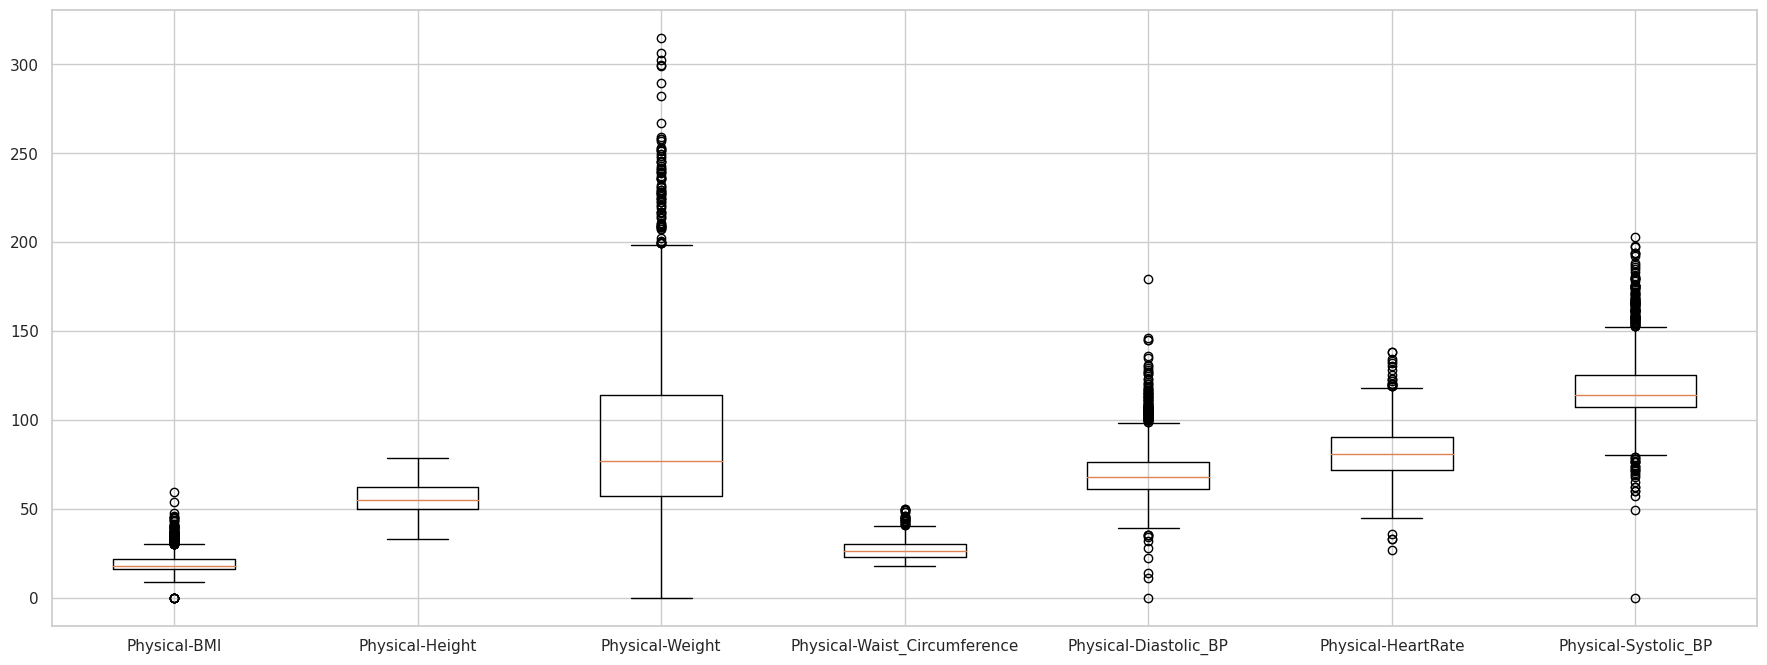

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def serialize(value):
    return pd.Series(value).dropna()
fig = plt.figure(figsize =(22, 8))

plt.boxplot([serialize(train['Physical-BMI']),
             serialize(train['Physical-Height']),
             serialize(train['Physical-Weight']),
             serialize(train['Physical-Waist_Circumference']),
             serialize(train['Physical-Diastolic_BP']),
             serialize(train['Physical-HeartRate']),
             serialize(train['Physical-Systolic_BP'])
            ],
           labels = ['Physical-BMI',
                     'Physical-Height', 
                     'Physical-Weight', 
                     'Physical-Waist_Circumference', 
                     'Physical-Diastolic_BP', 
                     'Physical-HeartRate',
                     'Physical-Systolic_BP'
                    ])

plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
Note: From the plot above, we can see that there are many outliers in some measures

- Diastolic Blood Pressure, Body Mass Index and Systolic Blood Pressure are real values and often vary within a range and can not be zero.
- Diastolic_BP is usually less than 80 for normal person
- Systolic_BP is usually less than 120 for normal person, 130 or higher means High Blood Pressure 
</div>

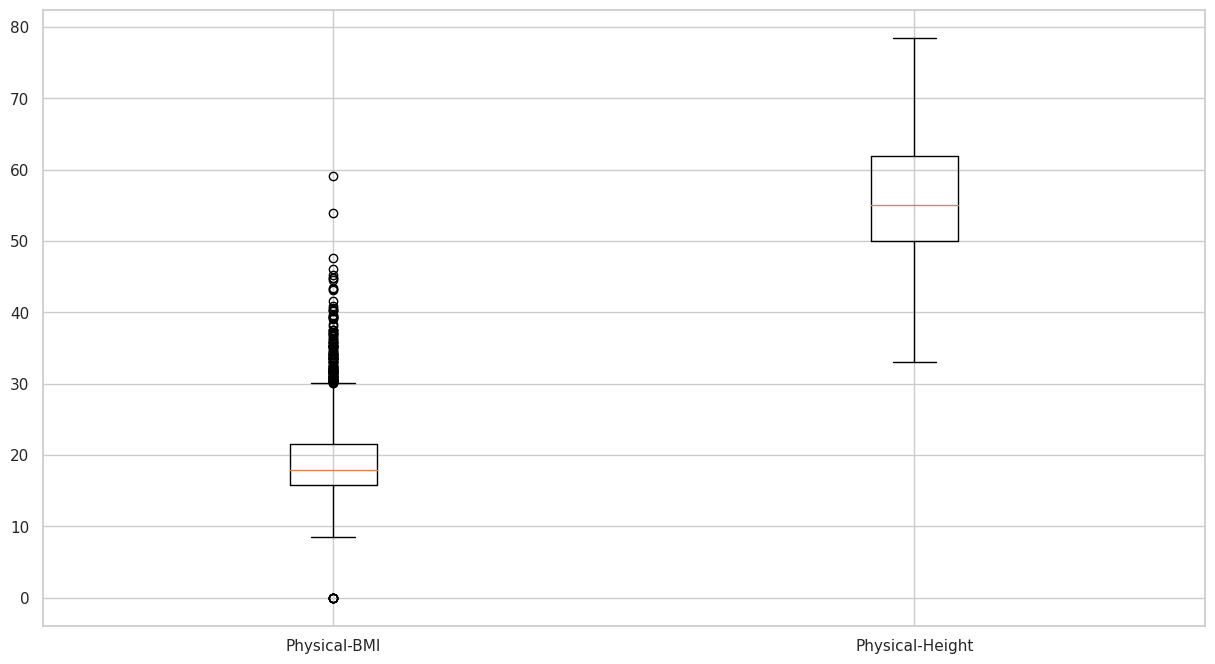

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def serialize(value):
    return pd.Series(value).dropna()
fig = plt.figure(figsize =(15, 8))

plt.boxplot([serialize(train['Physical-BMI']),
             serialize(train['Physical-Height']),

            ],
           labels = ['Physical-BMI',
                     'Physical-Height', 

                    ])

plt.show()

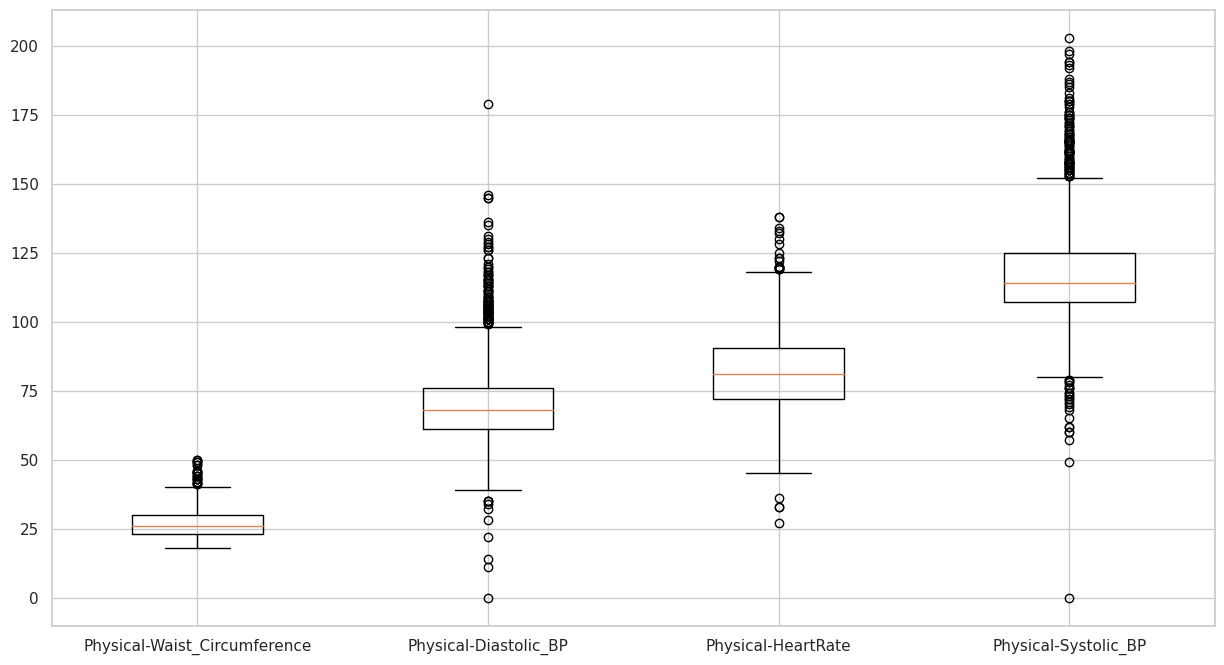

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def serialize(value):
    return pd.Series(value).dropna()
fig = plt.figure(figsize =(15, 8))

plt.boxplot([
             serialize(train['Physical-Waist_Circumference']),
             serialize(train['Physical-Diastolic_BP']),
             serialize(train['Physical-HeartRate']),
             serialize(train['Physical-Systolic_BP'])
            ],
           labels = [
                     'Physical-Waist_Circumference', 
                     'Physical-Diastolic_BP', 
                     'Physical-HeartRate',
                     'Physical-Systolic_BP'
                    ])

plt.show()

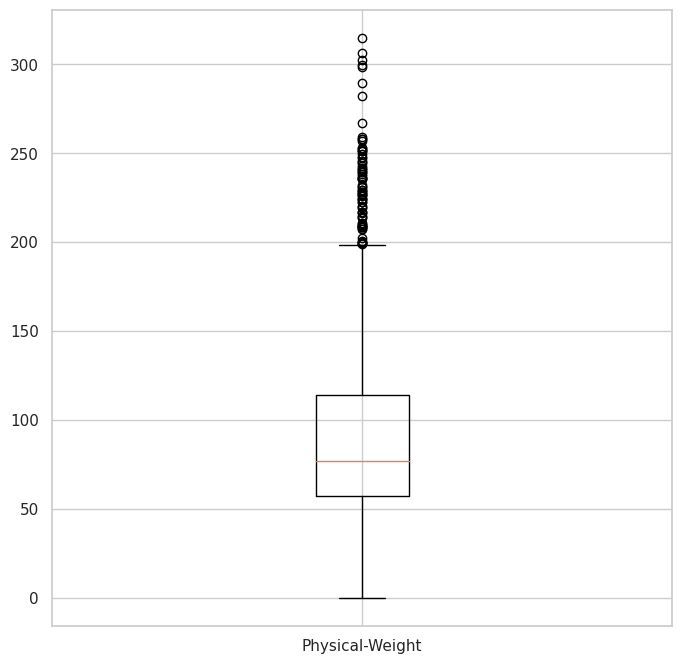

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def serialize(value):
    return pd.Series(value).dropna()
fig = plt.figure(figsize =(8, 8))

plt.boxplot([
             serialize(train['Physical-Weight']),

            ],
           labels = [
                     'Physical-Weight', 
                    ])

plt.show()

### Fitness Gram

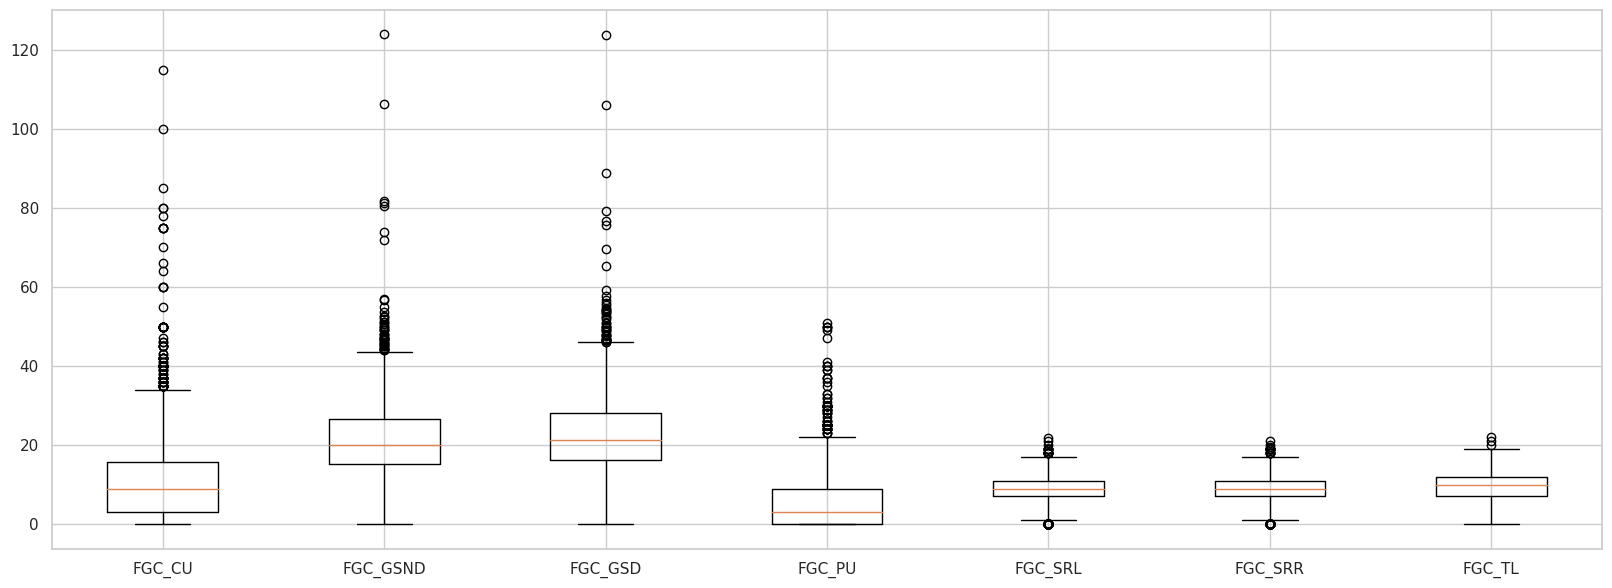

In [54]:
def serialize(value):
    return pd.Series(value).dropna()
fig = plt.figure(figsize =(20, 7))

plt.boxplot([serialize(train['FGC-FGC_CU']),
             serialize(train['FGC-FGC_GSND']),
             serialize(train['FGC-FGC_GSD']),
             serialize(train['FGC-FGC_PU']),
             serialize(train['FGC-FGC_SRL']),
             serialize(train['FGC-FGC_SRR']),
             serialize(train['FGC-FGC_TL'])
            ],
           labels = ['FGC_CU',
                     'FGC_GSND', 
                     'FGC_GSD', 
                     'FGC_PU', 
                     'FGC_SRL', 
                     'FGC_SRR',
                     'FGC_TL'
                    ])

plt.show()

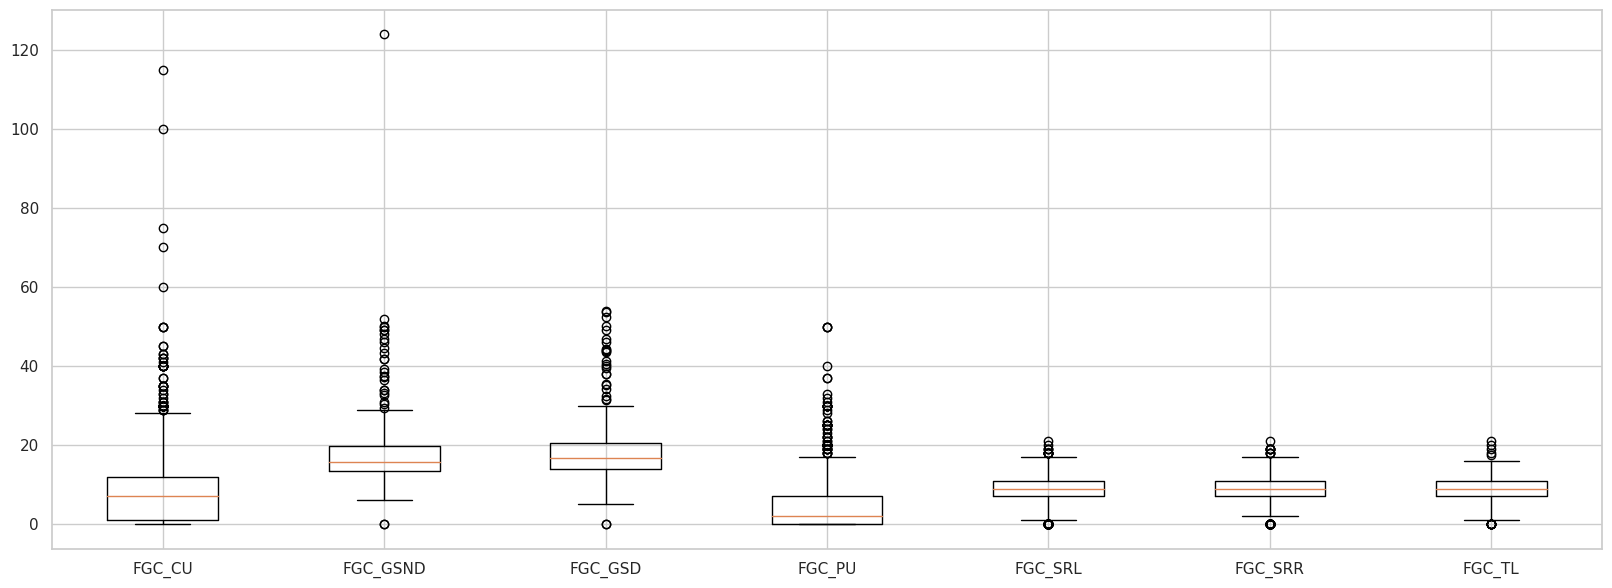

In [55]:
fig = plt.figure(figsize =(20, 7))
children = train.filter(train['Basic_Demos-Age'] <= 12)
plt.boxplot([serialize(children['FGC-FGC_CU']),
             serialize(children['FGC-FGC_GSND']),
             serialize(children['FGC-FGC_GSD']),
             serialize(children['FGC-FGC_PU']),
             serialize(children['FGC-FGC_SRL']),
             serialize(children['FGC-FGC_SRR']),
             serialize(children['FGC-FGC_TL'])
            ],
           labels = ['FGC_CU',
                     'FGC_GSND', 
                     'FGC_GSD', 
                     'FGC_PU', 
                     'FGC_SRL', 
                     'FGC_SRR',
                     'FGC_TL'
                    ])
plt.show()

### Bio-electric Impedance Analysis

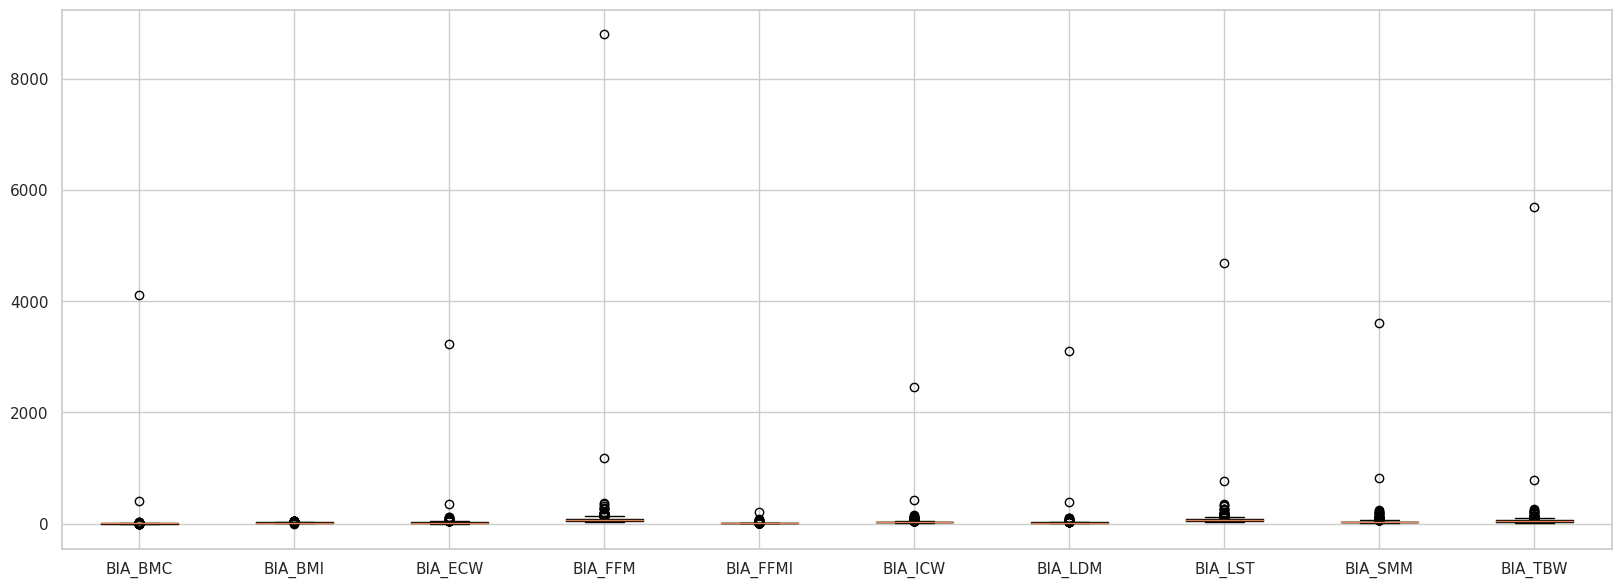

In [68]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([serialize(train['BIA-BIA_BMC']),
             serialize(train['BIA-BIA_BMI']),
             serialize(train['BIA-BIA_ECW']),
             serialize(train['BIA-BIA_FFM']),
             serialize(train['BIA-BIA_FFMI']),
             serialize(train['BIA-BIA_ICW']),
             serialize(train['BIA-BIA_LDM']),
             serialize(train['BIA-BIA_LST']),
             serialize(train['BIA-BIA_SMM']),
             serialize(train['BIA-BIA_TBW'])
            ],
           labels = ['BIA_BMC',
                     'BIA_BMI', 
                     'BIA_ECW', 
                     'BIA_FFM',
                     'BIA_FFMI',
                     'BIA_ICW',
                     'BIA_LDM',
                     'BIA_LST',
                     'BIA_SMM',
                     'BIA_TBW'
                    ])

plt.show()

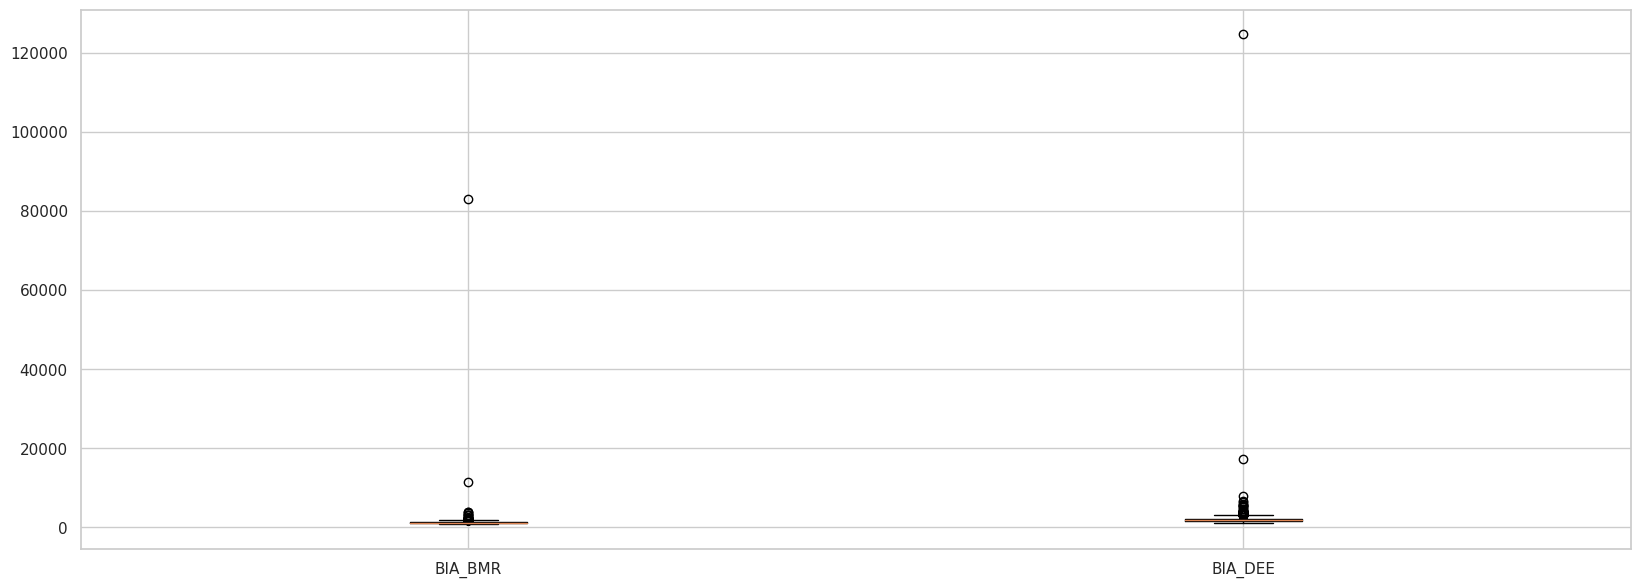

In [57]:
fig = plt.figure(figsize =(20, 7))
plt.boxplot([
             serialize(train['BIA-BIA_BMR']),
             serialize(train['BIA-BIA_DEE']),
            ],
           labels = [
                     'BIA_BMR', 
                     'BIA_DEE', 
                    ])

plt.show()

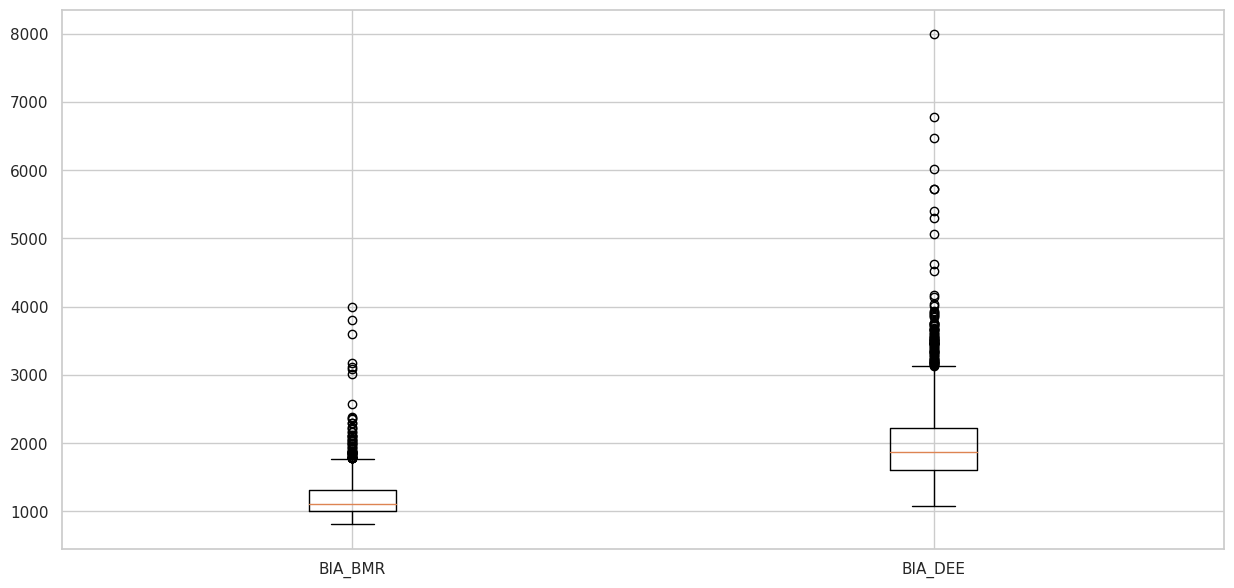

In [58]:
fig = plt.figure(figsize =(15, 7))

plt.boxplot([
             serialize(train.filter(train['BIA-BIA_BMR'] < 10000)['BIA-BIA_BMR']),
             serialize(train.filter(train['BIA-BIA_DEE'] < 10000)['BIA-BIA_DEE']),
            ],
           labels = [
                     'BIA_BMR', 
                     'BIA_DEE', 
                    ])

plt.show()

From these box plots and domain knowledge we can define the threshold to remove outliers

## Correlation

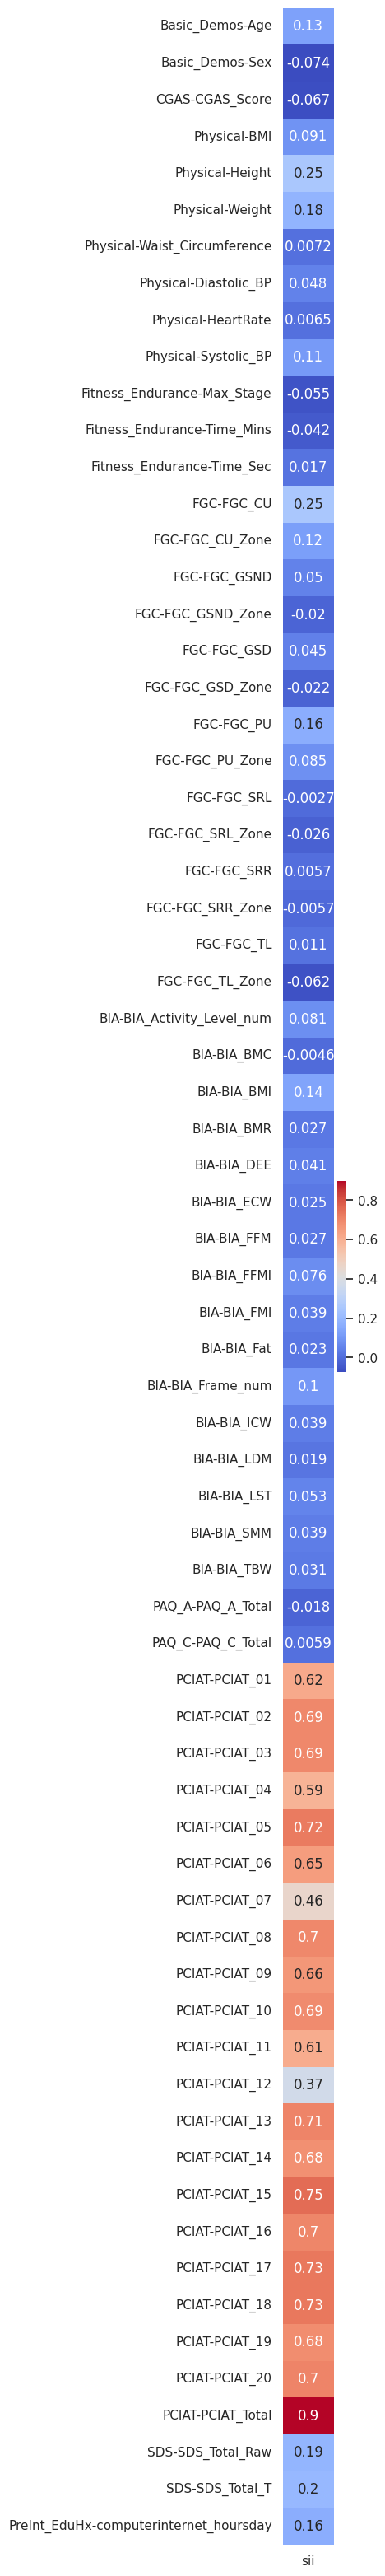

In [59]:
import pandas as pd
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')
sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

train_engineer = train
train_engineer['sii'] = train['sii'].cat.codes

season_cols = [col for col in train_engineer.columns if train_engineer[col].dtype == 'object']
train_engineer = train_engineer.drop(season_cols, axis=1)

corr_matrix_sii = train_engineer.corr()['sii'].drop('sii')
corr_df_sii = pd.DataFrame(corr_matrix_sii)
plt.figure(figsize=(1,40))
sns.heatmap(corr_df_sii, annot=True, cmap='coolwarm')
plt.show()

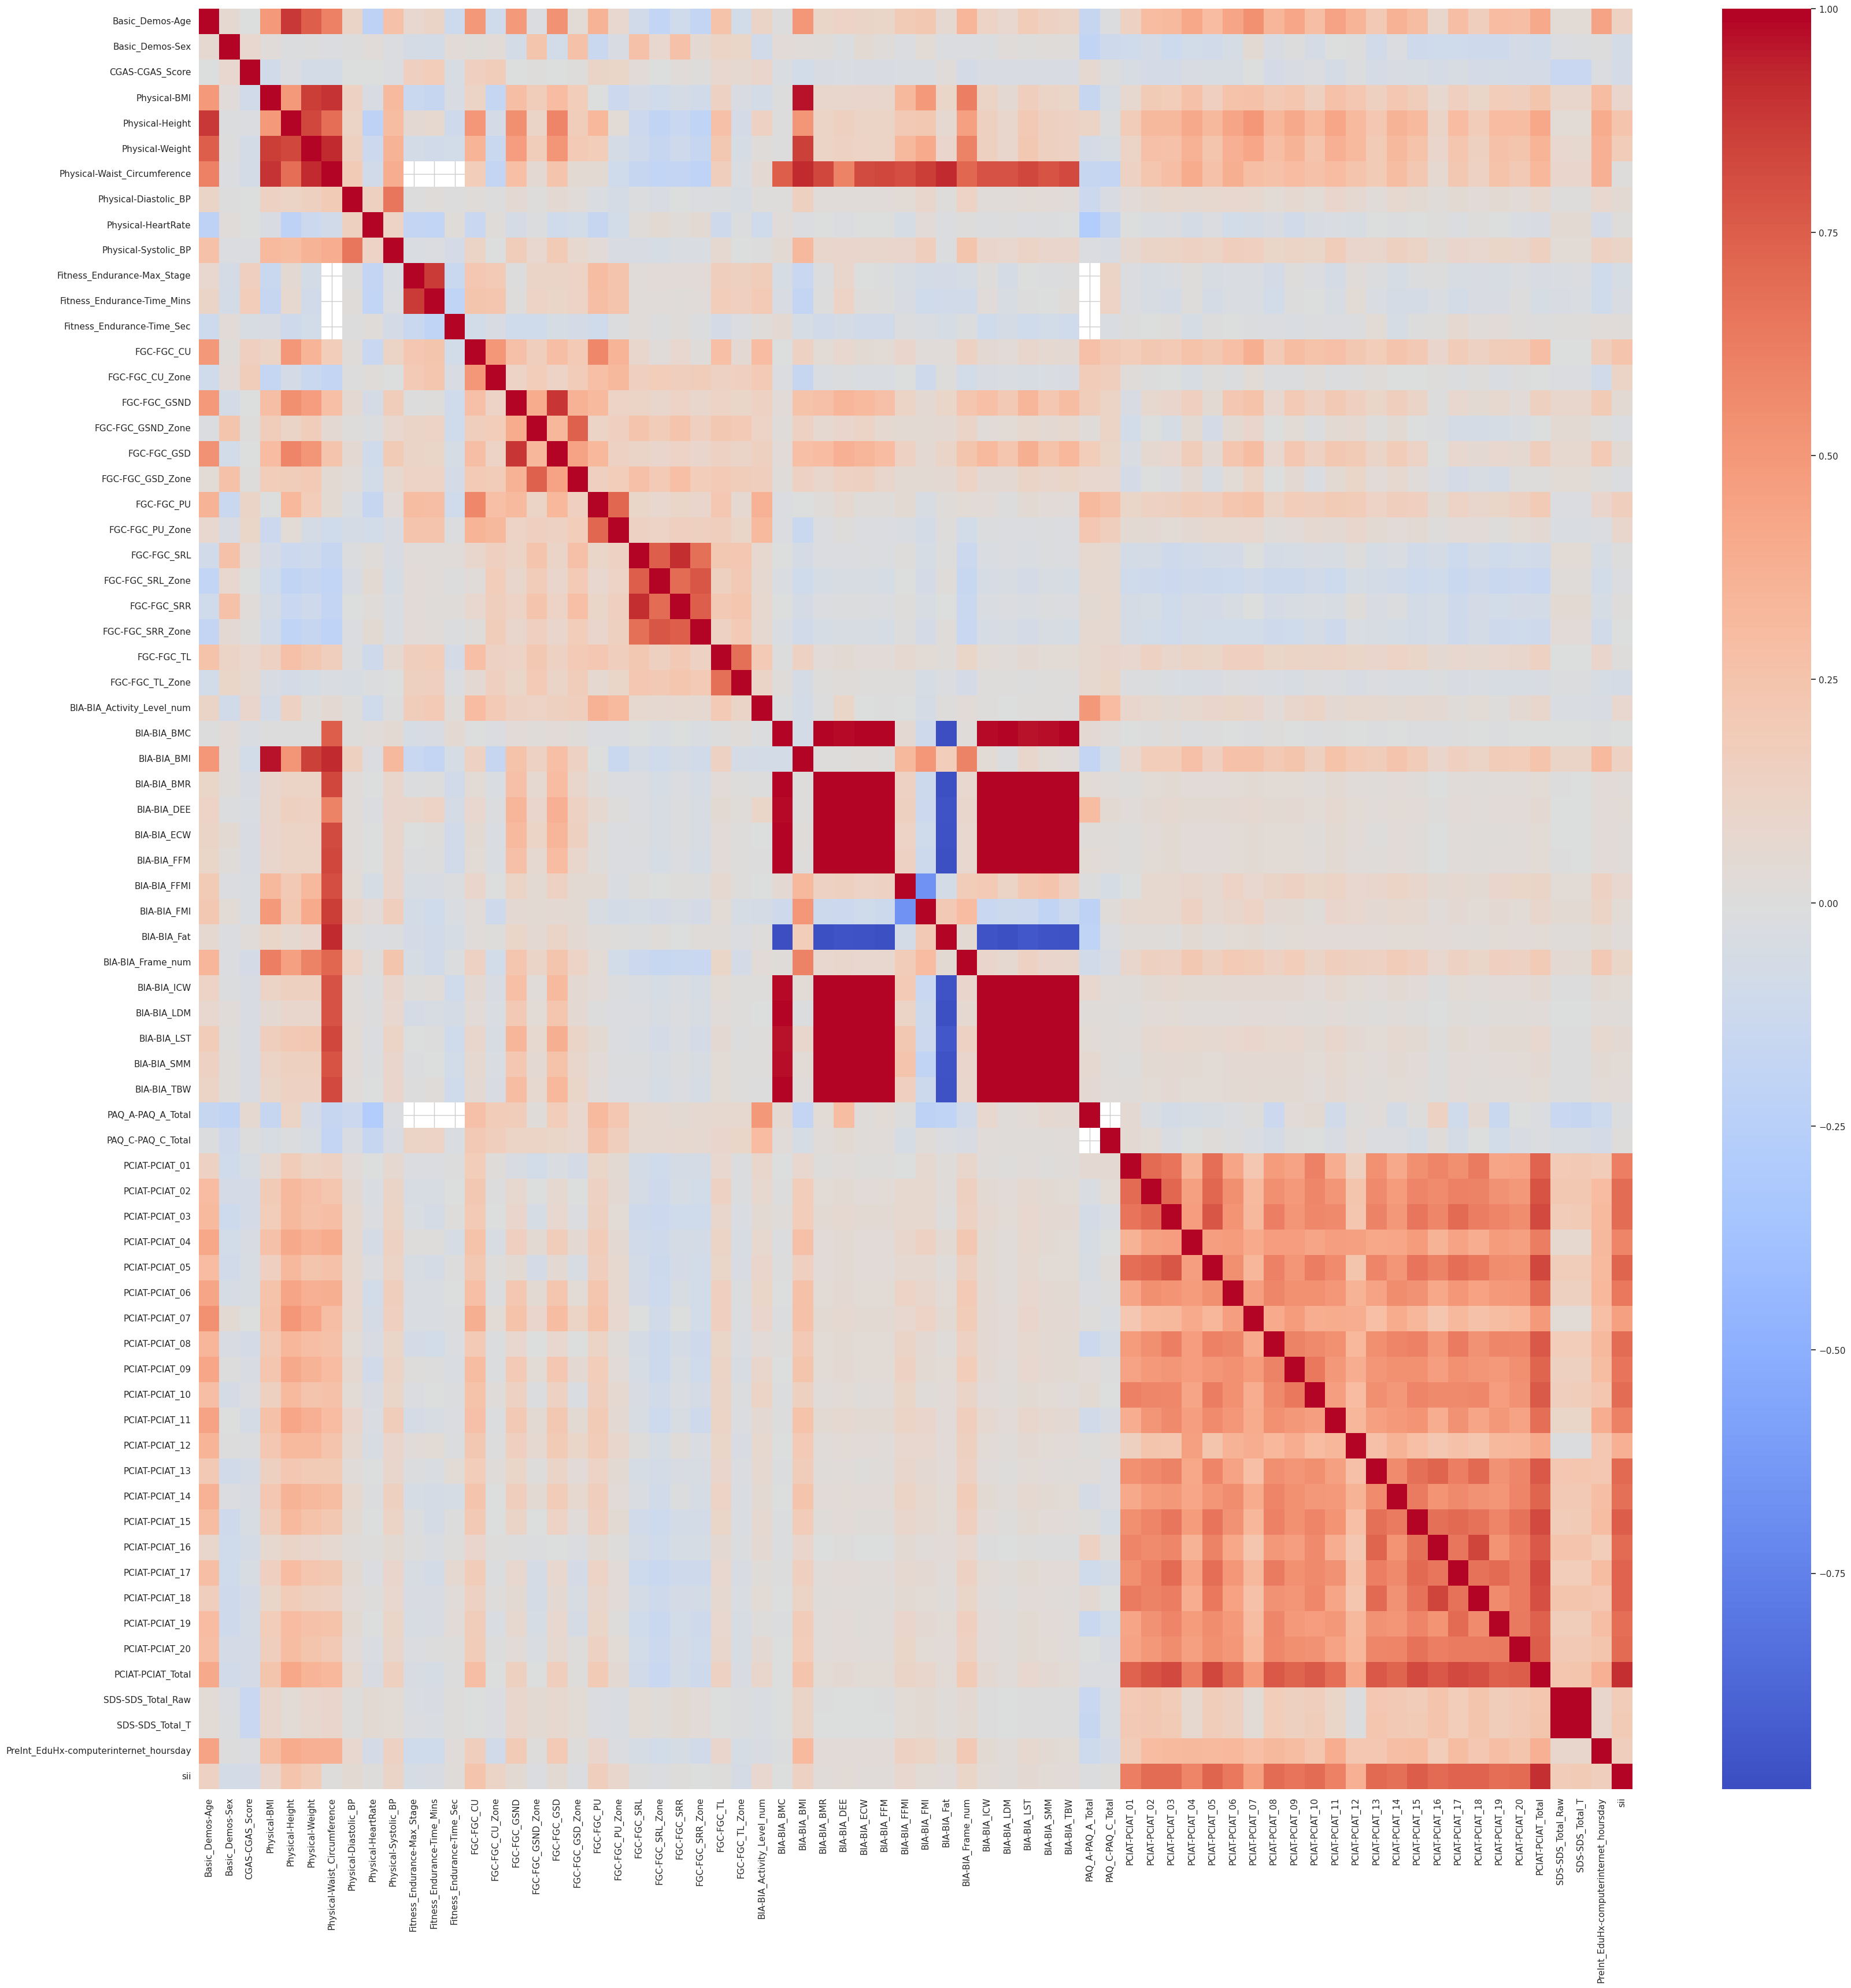

In [60]:
corr_matrix = train_engineer.corr()
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm',center = 0)
plt.show()

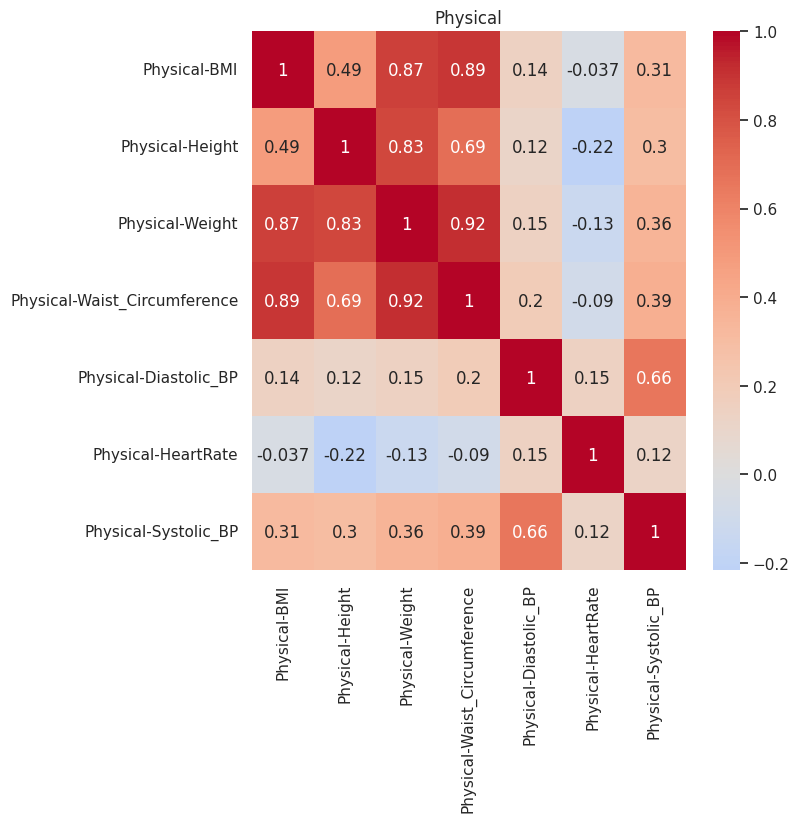

In [61]:
physical_cols = [col for col in train_engineer.columns if 'Physical' in col]
corr_matrix_physical = train_engineer[physical_cols].corr()[physical_cols]
plt.figure(figsize=(7,7))
sns.heatmap(corr_matrix_physical, annot=True, cmap='coolwarm', center = 0)
plt.title("Physical")
plt.show()

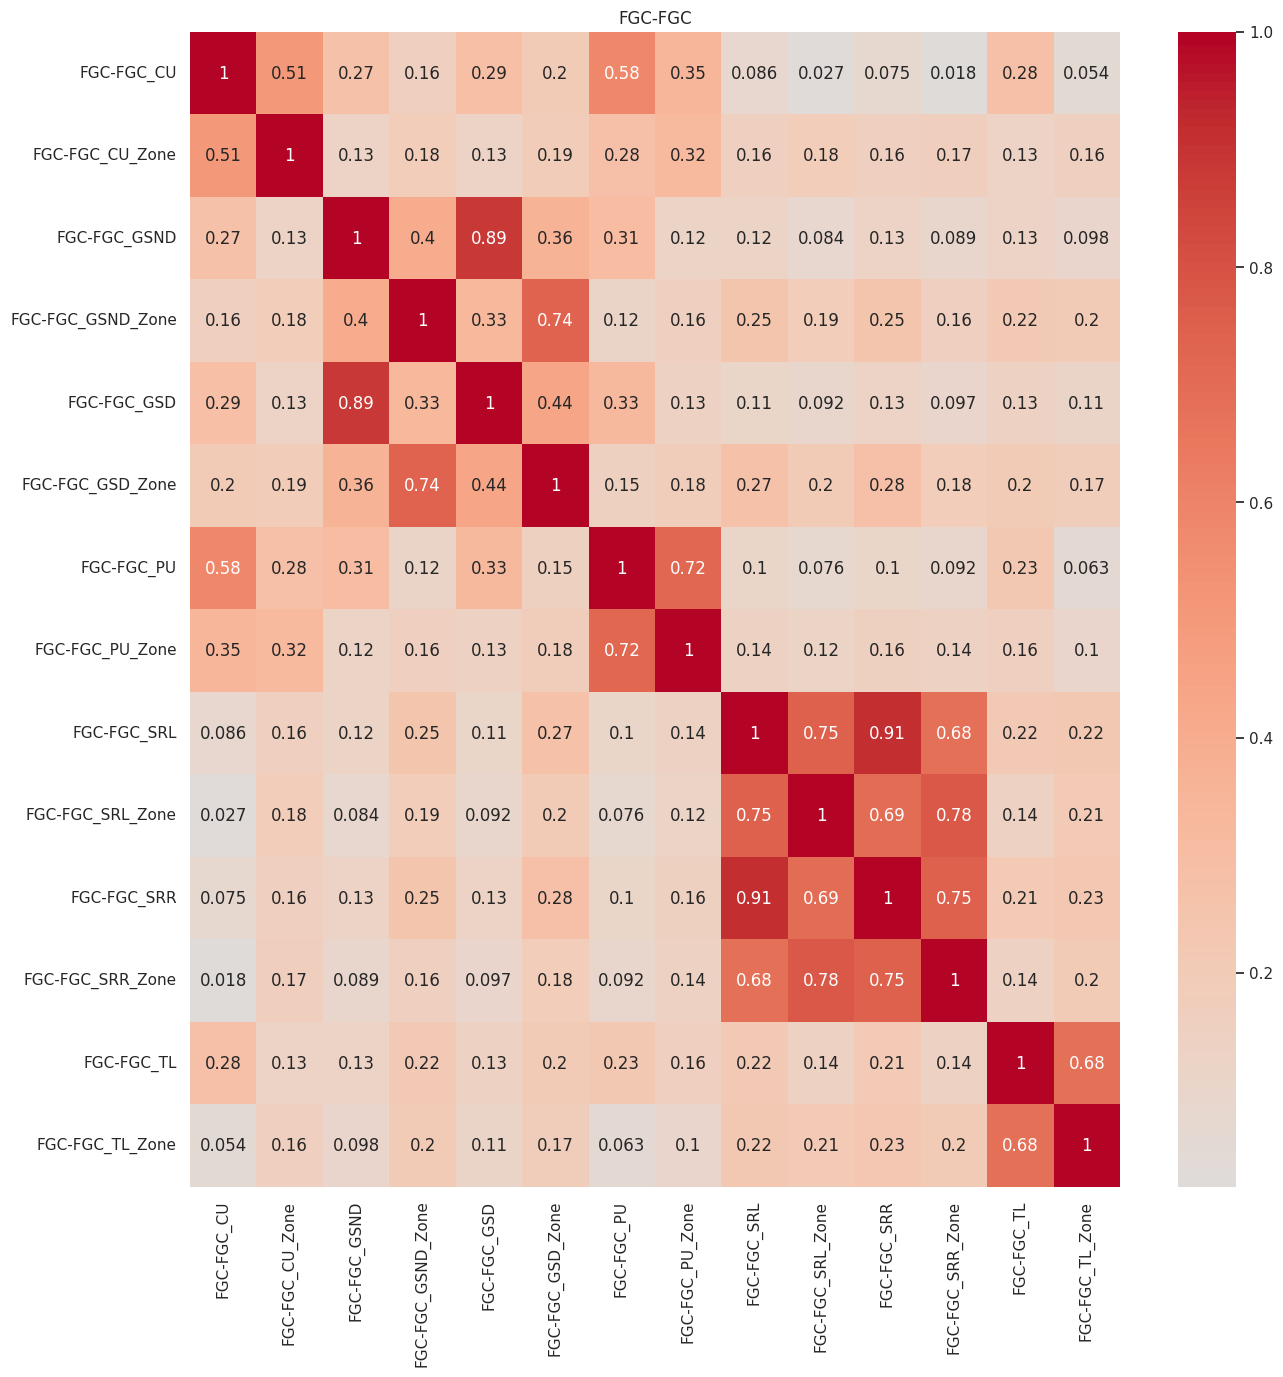

In [62]:
FGC_cols = [col for col in train_engineer.columns if 'FGC' in col]
corr_matrix_FGC = train_engineer[FGC_cols].corr()[FGC_cols]
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix_FGC, annot=True, cmap='coolwarm', center = 0)
plt.title("FGC-FGC")
plt.show()

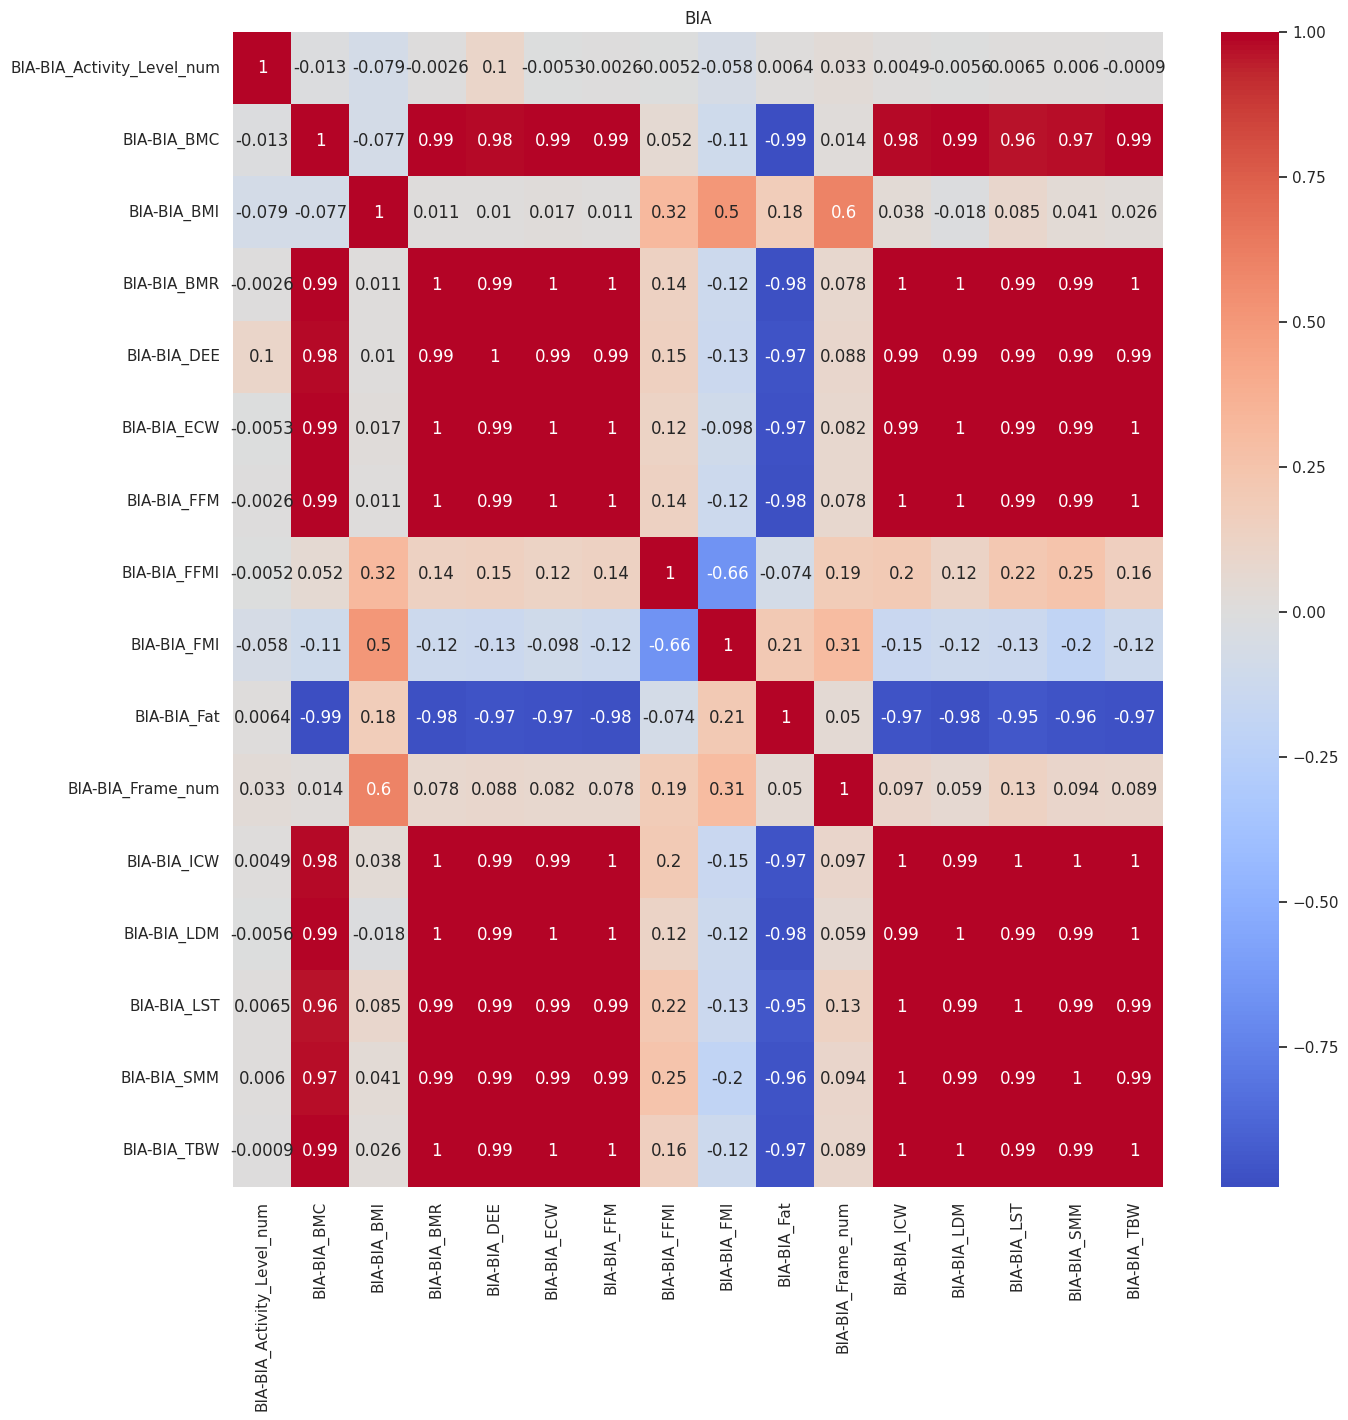

In [63]:
BIA_cols = [col for col in train_engineer.columns if 'BIA' in col]
corr_matrix_BIA = train_engineer[BIA_cols].corr()[BIA_cols]
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix_BIA, annot=True, cmap='coolwarm', center = 0)
plt.title("BIA")
plt.show()

## Actigraphy

In [64]:
train_ts[0][1]

,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0.239474,0.128193,-0.539177,0.092807,-42.693729,0.0,16.0,4143.000000,48000000000000,7,2,223.0
1,-0.168031,0.960363,-0.175933,0.057144,-10.230113,0.0,8.5,4142.333496,48005000000000,7,2,223.0
2,0.005663,0.925091,-0.345249,0.090669,-20.674137,0.0,26.0,4141.666504,48010000000000,7,2,223.0
3,0.638858,0.243702,-0.425669,0.079404,-28.251497,0.0,41.0,4141.000000,48015000000000,7,2,223.0
4,0.262944,0.273228,-0.796457,0.094136,-58.822552,0.0,11.5,4140.333496,48020000000000,7,2,223.0
...,...,...,...,...,...,...,...,...,...,...,...,...
340579,0.691592,0.324496,-0.625922,0.000000,-39.319786,0.0,6.0,3098.833252,22895000000000,6,2,243.0
340580,0.691734,0.324223,-0.626246,0.000004,-39.332798,0.0,6.0,3098.666748,22900000000000,6,2,243.0
340581,0.691863,0.324327,-0.626000,0.000000,-39.337654,0.0,6.0,3098.500000,22905000000000,6,2,243.0
340582,0.691540,0.324509,-0.625961,0.000000,-39.329155,0.0,6.0,3098.333252,22910000000000,6,2,243.0


In [65]:
train_ts[0][1].describe()

,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
count,340584.000000,340584.000000,340584.000000,340584.000000,340584.000000,340584.000000,340584.000000,340584.000000,3.405840e+05,340584.000000,340584.0,340584.000000
mean,0.113277,0.093139,-0.106038,0.028960,-6.065619,0.046508,56.437958,3829.466064,4.331149e+13,3.840885,2.0,232.909103
std,0.507897,0.541129,0.603787,0.096825,44.034721,0.208482,206.625092,167.600983,2.509136e+13,1.957999,0.0,5.701968
min,-1.807955,-2.887664,-1.004992,0.000000,-89.654587,0.000000,0.000000,3098.166748,0.000000e+00,1.000000,2.0,223.000000
25%,-0.231743,-0.257600,-0.595426,0.000367,-37.326844,0.000000,4.000000,3724.000000,2.128500e+13,2.000000,2.0,228.000000
50%,0.094074,0.068143,-0.228500,0.005257,-13.454103,0.000000,10.050480,3812.000000,4.360500e+13,4.000000,2.0,233.000000
75%,0.517859,0.542323,0.312333,0.020598,18.462269,0.000000,27.490936,3958.000000,6.511000e+13,5.000000,2.0,238.000000
max,1.928769,3.234613,2.475326,3.966906,89.080330,1.000000,2628.199951,4146.000000,8.639500e+13,7.000000,2.0,243.000000


In [66]:
train_ts[0][12]

,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0.267588,0.102066,-0.906937,0.062339,-70.114059,0.0,33.000000,4173.0,48360000000000,5,2,37.0
1,0.298566,0.624992,-0.456697,0.024176,-31.419353,0.0,0.000000,4171.5,48365000000000,5,2,37.0
2,0.230192,0.903685,-0.326257,0.007249,-19.023094,0.0,5.916667,4170.0,48370000000000,5,2,37.0
3,0.274420,0.824175,-0.302877,0.015919,-20.672569,0.0,11.833333,4168.5,48375000000000,5,2,37.0
4,0.529079,-0.701420,-0.159990,0.067875,-11.455811,0.0,17.750000,4167.0,48380000000000,5,2,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...
266901,0.789354,0.088200,-0.426377,0.103320,-26.385359,0.0,36.500000,3683.0,35245000000000,2,3,76.0
266902,0.419452,-0.081563,-0.572969,0.070539,-53.868462,0.0,22.000000,3683.0,35250000000000,2,3,76.0
266903,0.016320,0.014626,-0.991375,0.000003,-88.721573,0.0,22.000000,3683.0,35255000000000,2,3,76.0
266904,0.016587,0.013389,-0.991149,0.000006,-88.760971,0.0,22.000000,3683.0,35260000000000,2,3,76.0


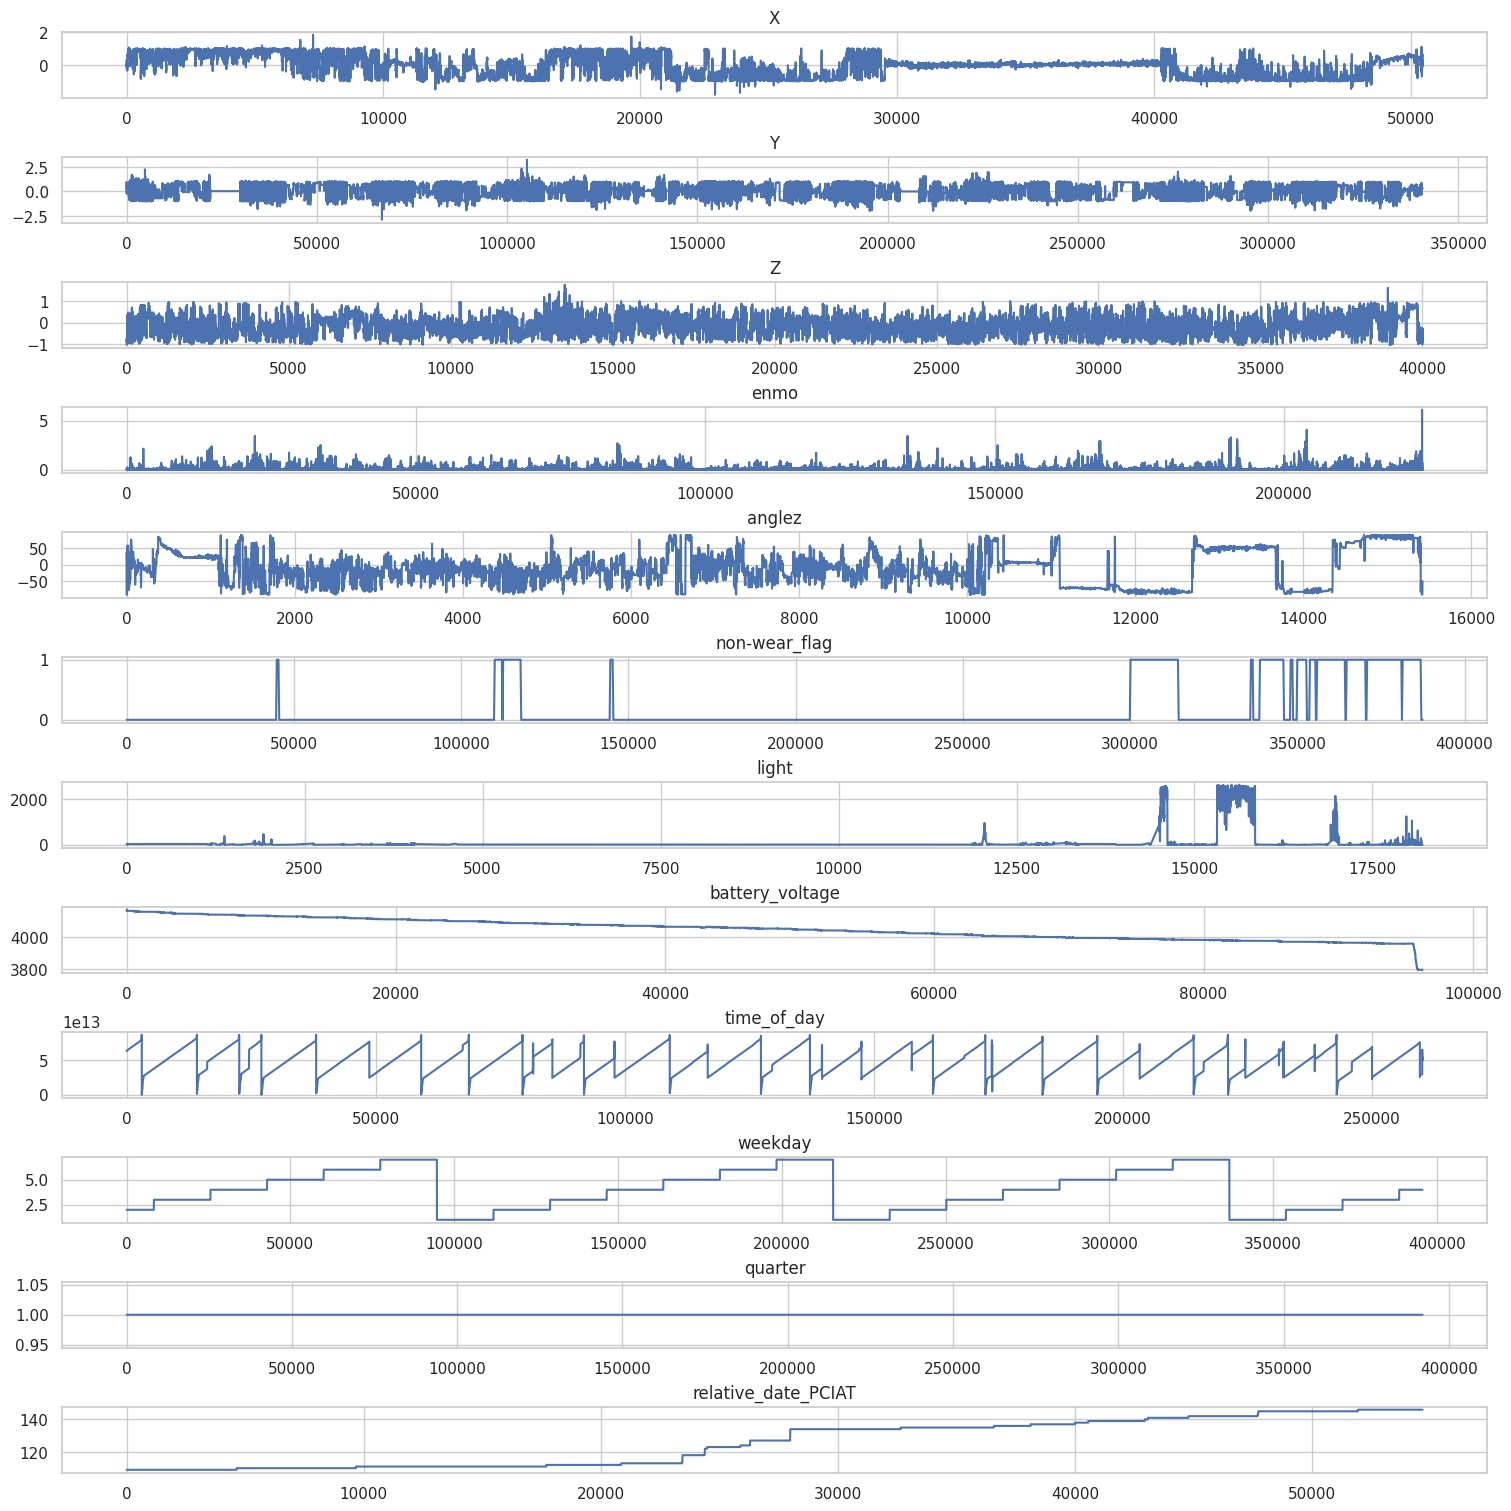

In [67]:
index = 1
fig, axis = plt.subplots(12, 1, constrained_layout = True)
fig.set_figwidth(15)
fig.set_figheight(15)

for index, col_name in enumerate(train_ts[0][index].columns):
    series = np.array(train_ts[0][index][col_name]);
    axis[index].plot(series)
    axis[index].set_title(col_name)